In [30]:
import pandas as pd

import matplotlib.pyplot as plt

import numpy as np


import xgboost
import lightgbm
import catboost
import sklearn
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor


import skforecast
from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import select_features
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import shap

In [38]:
def train_val_test_split(serie,tr_size=0.8,vl_size=0.1,ts_size=0.1):

     N = serie.shape[0]

     Ntrain = int(tr_size*N) # Número de datos de entrenamiento

     Nval = int(vl_size *N) # Número de datos de validación

     Ntest = N - Ntrain- Nval # Número de datos de prueba

     # Partición

     train = serie[0:Ntrain]
     val = serie[Ntrain:Ntrain+Nval]
     test = serie[Ntrain+Nval:]

     return train,val,test

In [17]:
def add_lags(df):

    df['lag1']= (df.index - pd.Timedelta('30 days')).map(target_map)

    df['lag2']= (df.index - pd.Timedelta('60 days')).map(target_map)

    df['lag3']= (df.index - pd.Timedelta('364 days')).map(target_map)

    return df

In [18]:
def create_attributes(df):
    df = df.copy()
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [19]:
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mse, rmse, mae, mape

In [20]:
df = pd.read_csv('BD preprocesada II.csv',sep=',')

# Formatear columna Fecha como datetime

df['Fecha'] = pd.to_datetime(df['Fecha'])

# df = df[['Fecha','AUM FIC']]

df = df.rename(columns={'Fecha':'ds','AUM FIC':'y'})

df.drop_duplicates(keep='first',inplace=True,ignore_index=False)

# Fecha como índice

df.set_index('ds',inplace=True)

df.tail()

,y,Efectivo,Reserva Bancaria,Del sector privado,Del sector público,Cuentas de ahorro,CDT 1/,Otros depósitos a la vista,Inflación anual %,Tasa de intervención de política monetaria (%),...,Tasa A 120 días,Tasa Entre 121 y 179 días,Tasa A 180 días,Tasa Entre 181 y 359 días,Tasa A 360 días,Tasa Superiores a 360 días,Tasa Captaciones a través de CDT por red de oficinas,Tasa Captaciones a través de CDT por tesorería,Valor hoy,VALOR
ds,,,,,,,,,,,,,,,,,,,,,
2024-08-03,8.276074e+07,113349.537115,41284.585441,55740.710863,12412.767407,298898.80099,308954.440917,11117.476384,7.16,11.25,...,0.100588,0.102314,0.102521,0.106169,0.107774,0.106101,0.10044,0.107696,343.99,4022.05
2024-08-04,8.277857e+07,113349.537115,41284.585441,55740.710863,12412.767407,298898.80099,308954.440917,11117.476384,7.16,11.25,...,0.100588,0.102314,0.102521,0.106169,0.107774,0.106101,0.10044,0.107696,343.99,4022.05
2024-08-05,8.297109e+07,113349.537115,41284.585441,55740.710863,12412.767407,298898.80099,308954.440917,11117.476384,7.16,11.25,...,0.100588,0.102314,0.102521,0.106169,0.107774,0.106101,0.10044,0.107696,343.99,4022.05
2024-08-06,8.339252e+07,113349.537115,41284.585441,55740.710863,12412.767407,298898.80099,308954.440917,11117.476384,7.16,11.25,...,0.100588,0.102314,0.102521,0.106169,0.107774,0.106101,0.10044,0.107696,343.99,4022.05
2024-08-07,8.335225e+07,113349.537115,41284.585441,55740.710863,12412.767407,298898.80099,308954.440917,11117.476384,7.16,11.25,...,0.100588,0.102314,0.102521,0.106169,0.107774,0.106101,0.10044,0.107696,343.99,4022.05


In [22]:
df_model = df.copy()

df_model

df_model = create_attributes(df_model)
df_model

,y,Efectivo,Reserva Bancaria,Del sector privado,Del sector público,Cuentas de ahorro,CDT 1/,Otros depósitos a la vista,Inflación anual %,Tasa de intervención de política monetaria (%),...,Tasa Captaciones a través de CDT por red de oficinas,Tasa Captaciones a través de CDT por tesorería,Valor hoy,VALOR,day,dayofweek,month,quarter,year,dayofyear
ds,,,,,,,,,,,,,,,,,,,,,
2018-01-01,4.277819e+07,58512.003886,28754.777759,35602.554628,10671.094981,170017.348229,160226.125352,5328.184972,3.68,4.75,...,0.052959,0.058457,286.55,2940.94,1,0,1,1,2018,1
2018-01-02,4.346588e+07,58512.003886,28754.777759,35602.554628,10671.094981,170017.348229,160226.125352,5328.184972,3.37,4.75,...,0.052959,0.058457,286.55,2940.94,2,1,1,1,2018,2
2018-01-03,4.427526e+07,58512.003886,28754.777759,35602.554628,10671.094981,170017.348229,160226.125352,5328.184972,3.37,4.75,...,0.052840,0.064005,286.55,2940.94,3,2,1,1,2018,3
2018-01-04,4.457223e+07,58512.003886,28754.777759,35602.554628,10671.094981,170017.348229,160226.125352,5328.184972,3.37,4.75,...,0.052695,0.064102,286.55,2908.68,4,3,1,1,2018,4
2018-01-05,4.464074e+07,58512.003886,28754.777759,35602.554628,10671.094981,170017.348229,160226.125352,5328.184972,3.37,4.75,...,0.052718,0.057780,286.55,2885.76,5,4,1,1,2018,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-03,8.276074e+07,113349.537115,41284.585441,55740.710863,12412.767407,298898.800990,308954.440917,11117.476384,7.16,11.25,...,0.100440,0.107696,343.99,4022.05,3,5,8,3,2024,216
2024-08-04,8.277857e+07,113349.537115,41284.585441,55740.710863,12412.767407,298898.800990,308954.440917,11117.476384,7.16,11.25,...,0.100440,0.107696,343.99,4022.05,4,6,8,3,2024,217
2024-08-05,8.297109e+07,113349.537115,41284.585441,55740.710863,12412.767407,298898.800990,308954.440917,11117.476384,7.16,11.25,...,0.100440,0.107696,343.99,4022.05,5,0,8,3,2024,218


In [23]:
df_model = df_model.asfreq('D')

In [40]:
tr,val,ts = train_val_test_split(df_model)

print(f'Tamaño set de entrenamiento: {tr.shape}')

print(f'Tamaño set de validación: {val.shape}')

print(f'Tamaño set de prueba: {ts.shape}')

Tamaño set de entrenamiento: (1928, 34)
Tamaño set de validación: (241, 34)
Tamaño set de prueba: (242, 34)


In [47]:
end_validation = '2023-12-09'

end_train = '2023-04-12'

## LightGBM

In [54]:
# Create forecaster
# ==============================================================================
forecaster_1 = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=15926, verbose=-1),
                 lags      = 24
             )

# Train forecaster
# ==============================================================================
forecaster_1.fit(y=df_model.loc[:end_validation, 'y'])
forecaster_1

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=15926, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2018-01-01 00:00:00'), Timestamp('2023-12-09 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 15926, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs

In [55]:
# Predictions
# ==============================================================================
steps = 242
predictions_1 = forecaster_1.predict(steps=steps)
predictions_1.head(5)

2023-12-10    7.134037e+07
2023-12-11    7.133786e+07
2023-12-12    7.155473e+07
2023-12-13    7.143252e+07
2023-12-14    7.108293e+07
Freq: D, Name: pred, dtype: float64

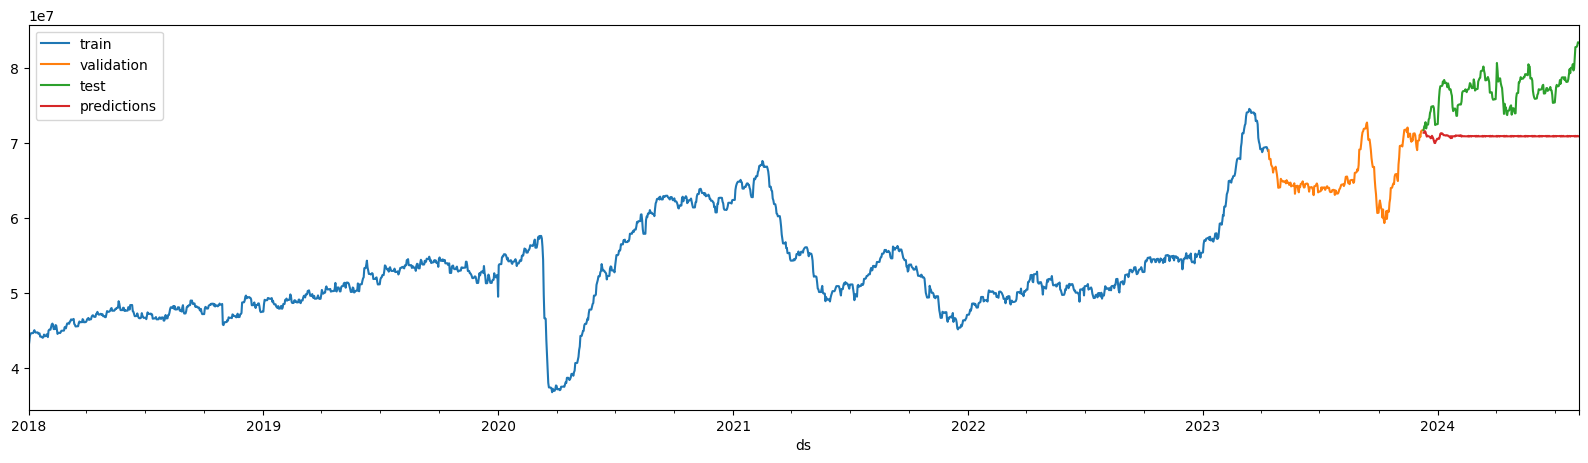

In [57]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(20, 5))
tr['y'].plot(ax=ax, label='train')
val['y'].plot(ax=ax, label='validation')
ts['y'].plot(ax=ax, label='test')
predictions_1.plot(ax=ax, label='predictions')
ax.legend();

In [58]:
metricas_lightbm= calculate_metrics(ts['y'],predictions_1)

### Backtesting

In [59]:
metric_1, predictions_1_backtesting = backtesting_forecaster(
                          forecaster         = forecaster_1,
                          y                  = df_model['y'],
                          steps              = 30,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(df_model[:end_validation]),
                          refit              = True,
                          n_jobs             = 'auto',
                          verbose            = True, # Change to False to see less information
                          show_progress      = True
                      )

display(metric_1)

predictions_1_backtesting.head()

Information of backtesting process
----------------------------------
Number of observations used for initial training: 2169
Number of observations used for backtesting: 242
    Number of folds: 9
    Number of steps per fold: 30
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2018-01-01 00:00:00 -- 2023-12-09 00:00:00  (n=2169)
    Validation: 2023-12-10 00:00:00 -- 2024-01-08 00:00:00  (n=30)
Fold: 1
    Training:   2018-01-31 00:00:00 -- 2024-01-08 00:00:00  (n=2169)
    Validation: 2024-01-09 00:00:00 -- 2024-02-07 00:00:00  (n=30)
Fold: 2
    Training:   2018-03-02 00:00:00 -- 2024-02-07 00:00:00  (n=2169)
    Validation: 2024-02-08 00:00:00 -- 2024-03-08 00:00:00  (n=30)
Fold: 3
    Training:   2018-04-01 00:00:00 -- 2024-03-08 00:00:00  (n=2169)
    Validation: 2024-03-09 00:00:00 -- 2024-04-07 00:00:00  (n=30)
Fold: 4
    Training:   2018-05-01 00:00:00 -- 2024-04-07 00:00:00

100%|██████████| 9/9 [00:00<?, ?it/s]


1817723.7462069215

,pred
2023-12-10,7.134037e+07
2023-12-11,7.133786e+07
2023-12-12,7.155473e+07
2023-12-13,7.143252e+07
2023-12-14,7.108293e+07


In [61]:
metricas_lightbm_2= calculate_metrics(ts['y'],predictions_1_backtesting)

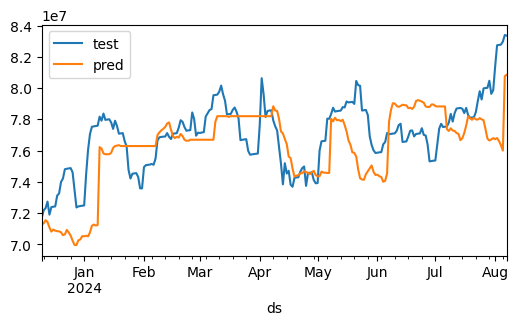

In [68]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
ts['y'].plot(ax=ax, label='test')
predictions_1_backtesting.plot(ax=ax)
ax.legend()
plt.show();

### Hiperparámetros

In [63]:
# Hyperparameters search
# ==============================================================================
# Lags grid
lags_grid = [120,150,180]

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 25, 500),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 0.5),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1, step=0.1),
        'max_bin'         : trial.suggest_int('max_bin', 50, 250, step=25),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
    forecaster         = forecaster_1,
    y                  = df_model.loc[:end_validation, 'y'], # Test data not used
    search_space       = search_space,
    steps              = 30,
    refit              = False,
    metric             = 'mean_absolute_error',
    initial_train_size = len(tr),
    fixed_train_size   = False,
    n_trials           = 20, # Increase this value for a more exhaustive search
    random_state       = 123,
    return_best        = True,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)

Best trial: 0. Best value: 2.33576e+06: 100%|██████████| 20/20 [00:11<00:00,  1.67it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120] 
  Parameters: {'n_estimators': 1000, 'max_depth': 5, 'min_data_in_leaf': 132, 'learning_rate': 0.28014423685061673, 'feature_fraction': 0.9, 'max_bin': 125, 'reg_alpha': 1.0, 'reg_lambda': 0.7000000000000001}
  Backtesting metric: 2335762.733150421



In [64]:
metric_2, predictions_2_backtesting = backtesting_forecaster(
                          forecaster         = forecaster_1,
                          y                  = df_model['y'],
                          steps              = 30,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(df_model[:end_validation]),
                          refit              = True,
                          n_jobs             = 'auto',
                          verbose            = True, # Change to False to see less information
                          show_progress      = True
                      )

display(metric_2)

predictions_2_backtesting.head()

Information of backtesting process
----------------------------------
Number of observations used for initial training: 2169
Number of observations used for backtesting: 242
    Number of folds: 9
    Number of steps per fold: 30
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2018-01-01 00:00:00 -- 2023-12-09 00:00:00  (n=2169)
    Validation: 2023-12-10 00:00:00 -- 2024-01-08 00:00:00  (n=30)
Fold: 1
    Training:   2018-01-31 00:00:00 -- 2024-01-08 00:00:00  (n=2169)
    Validation: 2024-01-09 00:00:00 -- 2024-02-07 00:00:00  (n=30)
Fold: 2
    Training:   2018-03-02 00:00:00 -- 2024-02-07 00:00:00  (n=2169)
    Validation: 2024-02-08 00:00:00 -- 2024-03-08 00:00:00  (n=30)
Fold: 3
    Training:   2018-04-01 00:00:00 -- 2024-03-08 00:00:00  (n=2169)
    Validation: 2024-03-09 00:00:00 -- 2024-04-07 00:00:00  (n=30)
Fold: 4
    Training:   2018-05-01 00:00:00 -- 2024-04-07 00:00:00

100%|██████████| 9/9 [00:00<00:00, 9002.80it/s]


2409906.7633315865

,pred
2023-12-10,7.007358e+07
2023-12-11,7.020339e+07
2023-12-12,6.918450e+07
2023-12-13,6.897245e+07
2023-12-14,6.911673e+07


In [66]:
metricas_lightbm_3= calculate_metrics(ts['y'],predictions_2_backtesting)

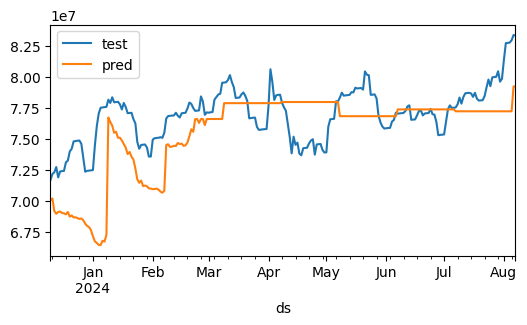

In [67]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
ts['y'].plot(ax=ax, label='test')
predictions_2_backtesting.plot(ax=ax)
ax.legend()
plt.show();

## Variables Exógenas

In [73]:
# Create and train forecaster
# ==============================================================================
forecaster_2 = ForecasterAutoreg(
                 regressor = LGBMRegressor(n_estimators = 100,max_depth=3,learning_rate= 0.1,random_state=123),
                 lags      = 150
             )
forecaster_2.fit(y=df_model.loc[:end_validation, 'y'],exog=df_model.loc[:end_validation,['Efectivo', 'Reserva Bancaria', 'Del sector privado',
       'Del sector público', 'Cuentas de ahorro', 'CDT 1/',
       'Otros depósitos a la vista', 'Inflación anual %',
       'Tasa de intervención de política monetaria (%)', 'Tasa 30 días',
       'Tasa Entre 31 y 44 días', 'Tasa A 45 días', 'Tasa Entre 46 y 59 días',
       'Tasa A 60 días', 'Tasa Entre 61 y 89 días', 'Tasa A 90 días',
       'Tasa Entre 91 y 119 días', 'Tasa A 120 días',
       'Tasa Entre 121 y 179 días', 'Tasa A 180 días',
       'Tasa Entre 181 y 359 días', 'Tasa A 360 días',
       'Tasa Superiores a 360 días',
       'Tasa Captaciones a través de CDT por red de oficinas',
       'Tasa Captaciones a través de CDT por tesorería', 'Valor hoy', 'VALOR',
       'day', 'dayofweek', 'month', 'quarter', 'year', 'dayofyear']])
forecaster_2


ForecasterAutoreg 
Regressor: LGBMRegressor(max_depth=3, random_state=123) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150] 
Transformer for y: None 
Transformer for exog: None 
Window size: 150 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['Efectivo', 'Reserva Bancaria', 'Del sector privado',

In [74]:
# Predictions
# ==============================================================================
steps = 242
predictions_2 = forecaster_2.predict(steps=steps,exog=ts[['Efectivo', 'Reserva Bancaria', 'Del sector privado',
       'Del sector público', 'Cuentas de ahorro', 'CDT 1/',
       'Otros depósitos a la vista', 'Inflación anual %',
       'Tasa de intervención de política monetaria (%)', 'Tasa 30 días',
       'Tasa Entre 31 y 44 días', 'Tasa A 45 días', 'Tasa Entre 46 y 59 días',
       'Tasa A 60 días', 'Tasa Entre 61 y 89 días', 'Tasa A 90 días',
       'Tasa Entre 91 y 119 días', 'Tasa A 120 días',
       'Tasa Entre 121 y 179 días', 'Tasa A 180 días',
       'Tasa Entre 181 y 359 días', 'Tasa A 360 días',
       'Tasa Superiores a 360 días',
       'Tasa Captaciones a través de CDT por red de oficinas',
       'Tasa Captaciones a través de CDT por tesorería', 'Valor hoy', 'VALOR',
       'day', 'dayofweek', 'month', 'quarter', 'year', 'dayofyear']])
predictions_2.head(5)

2023-12-10    7.167437e+07
2023-12-11    7.153695e+07
2023-12-12    7.124447e+07
2023-12-13    7.113191e+07
2023-12-14    7.116050e+07
Freq: D, Name: pred, dtype: float64

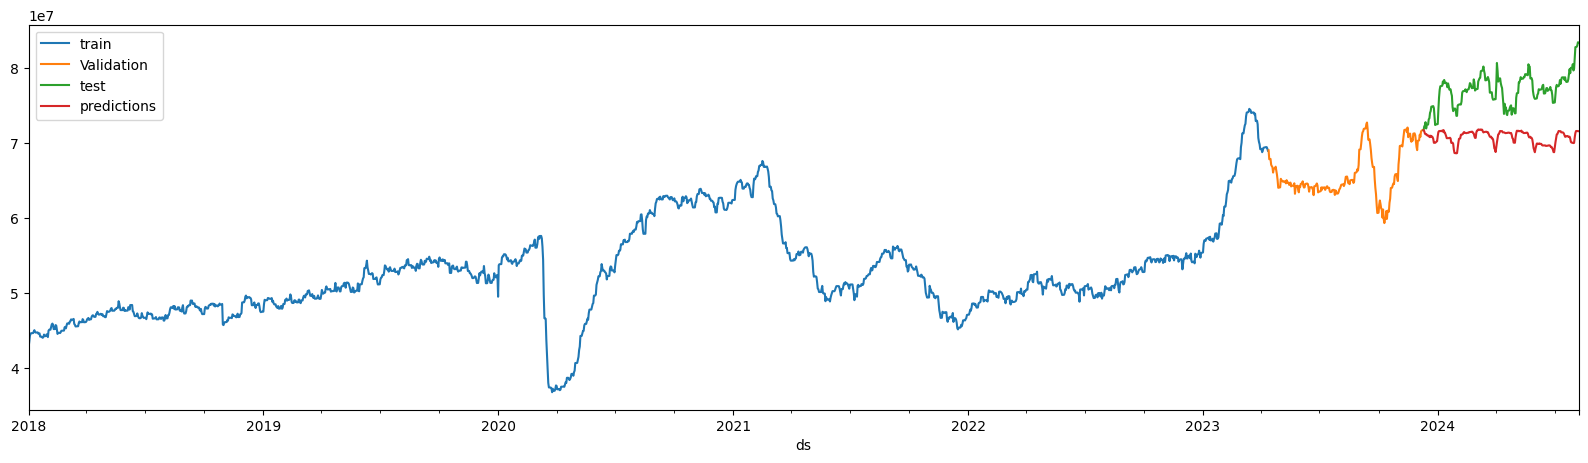

In [76]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(20, 5))
tr['y'].plot(ax=ax, label='train')
val['y'].plot(ax=ax, label='Validation')
ts['y'].plot(ax=ax, label='test')
predictions_2.plot(ax=ax, label='predictions')
ax.legend();

In [102]:
metricas_lightbm_4= calculate_metrics(ts['y'],predictions_2)

In [78]:
metric_3, predictions_3_backtesting = backtesting_forecaster(
                          forecaster         = forecaster_2,
                          y                  = df_model['y'],
                          exog= df_model[['Efectivo', 'Reserva Bancaria', 'Del sector privado',
       'Del sector público', 'Cuentas de ahorro', 'CDT 1/',
       'Otros depósitos a la vista', 'Inflación anual %',
       'Tasa de intervención de política monetaria (%)', 'Tasa 30 días',
       'Tasa Entre 31 y 44 días', 'Tasa A 45 días', 'Tasa Entre 46 y 59 días',
       'Tasa A 60 días', 'Tasa Entre 61 y 89 días', 'Tasa A 90 días',
       'Tasa Entre 91 y 119 días', 'Tasa A 120 días',
       'Tasa Entre 121 y 179 días', 'Tasa A 180 días',
       'Tasa Entre 181 y 359 días', 'Tasa A 360 días',
       'Tasa Superiores a 360 días',
       'Tasa Captaciones a través de CDT por red de oficinas',
       'Tasa Captaciones a través de CDT por tesorería', 'Valor hoy', 'VALOR',
       'day', 'dayofweek', 'month', 'quarter', 'year', 'dayofyear']],
                          steps              = 30,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(df_model[:end_validation]),
                          refit              = True,
                          n_jobs             = 'auto',
                          verbose            = True, # Change to False to see less information
                          show_progress      = True
                      )

display(metric_3)

predictions_3_backtesting.head()

Information of backtesting process
----------------------------------
Number of observations used for initial training: 2169
Number of observations used for backtesting: 242
    Number of folds: 9
    Number of steps per fold: 30
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2018-01-01 00:00:00 -- 2023-12-09 00:00:00  (n=2169)
    Validation: 2023-12-10 00:00:00 -- 2024-01-08 00:00:00  (n=30)
Fold: 1
    Training:   2018-01-31 00:00:00 -- 2024-01-08 00:00:00  (n=2169)
    Validation: 2024-01-09 00:00:00 -- 2024-02-07 00:00:00  (n=30)
Fold: 2
    Training:   2018-03-02 00:00:00 -- 2024-02-07 00:00:00  (n=2169)
    Validation: 2024-02-08 00:00:00 -- 2024-03-08 00:00:00  (n=30)
Fold: 3
    Training:   2018-04-01 00:00:00 -- 2024-03-08 00:00:00  (n=2169)
    Validation: 2024-03-09 00:00:00 -- 2024-04-07 00:00:00  (n=30)
Fold: 4
    Training:   2018-05-01 00:00:00 -- 2024-04-07 00:00:00

100%|██████████| 9/9 [00:00<00:00, 8998.51it/s]


1856040.5283975552

,pred
2023-12-10,7.167437e+07
2023-12-11,7.153695e+07
2023-12-12,7.124447e+07
2023-12-13,7.113191e+07
2023-12-14,7.116050e+07


In [103]:
metricas_lightbm_5= calculate_metrics(ts['y'],predictions_3_backtesting)

### Búsqueda de Hiperparámetros

In [81]:
# Hyperparameters search
# ==============================================================================

exog = df_model[['Efectivo', 'Reserva Bancaria', 'Del sector privado',
       'Del sector público', 'Cuentas de ahorro', 'CDT 1/',
       'Otros depósitos a la vista', 'Inflación anual %',
       'Tasa de intervención de política monetaria (%)', 'Tasa 30 días',
       'Tasa Entre 31 y 44 días', 'Tasa A 45 días', 'Tasa Entre 46 y 59 días',
       'Tasa A 60 días', 'Tasa Entre 61 y 89 días', 'Tasa A 90 días',
       'Tasa Entre 91 y 119 días', 'Tasa A 120 días',
       'Tasa Entre 121 y 179 días', 'Tasa A 180 días',
       'Tasa Entre 181 y 359 días', 'Tasa A 360 días',
       'Tasa Superiores a 360 días',
       'Tasa Captaciones a través de CDT por red de oficinas',
       'Tasa Captaciones a través de CDT por tesorería', 'Valor hoy', 'VALOR',
       'day', 'dayofweek', 'month', 'quarter', 'year', 'dayofyear']]


# Lags grid
lags_grid = [120,150,180]

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 25, 500),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 0.5),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1, step=0.1),
        'max_bin'         : trial.suggest_int('max_bin', 50, 250, step=25),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
    forecaster         = forecaster_2,
    y                  = df_model['y'],
    exog               = exog,
    search_space       = search_space,
    steps              = 36,
    refit              = False,
    metric             = 'mean_absolute_error',
    initial_train_size = len(tr),
    fixed_train_size   = False,
    n_trials           = 20,
    random_state       = 123,
    return_best        = True,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)
best_params = results_search['params'].iat[0]
best_lags = results_search['lags'].iat[0]

Best trial: 15. Best value: 4.05889e+06: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180] 
  Parameters: {'n_estimators': 800, 'max_depth': 8, 'min_data_in_leaf': 27, 'learning_rate': 0.1061729796195016, 'feature_fraction': 0.6, 'max_bin': 100, 'reg_alpha': 0.30

In [83]:
metric_4, predictions_4_backtesting = backtesting_forecaster(
                          forecaster         = forecaster_2,
                          y                  = df_model['y'],
                          exog= df_model[['Efectivo', 'Reserva Bancaria', 'Del sector privado',
       'Del sector público', 'Cuentas de ahorro', 'CDT 1/',
       'Otros depósitos a la vista', 'Inflación anual %',
       'Tasa de intervención de política monetaria (%)', 'Tasa 30 días',
       'Tasa Entre 31 y 44 días', 'Tasa A 45 días', 'Tasa Entre 46 y 59 días',
       'Tasa A 60 días', 'Tasa Entre 61 y 89 días', 'Tasa A 90 días',
       'Tasa Entre 91 y 119 días', 'Tasa A 120 días',
       'Tasa Entre 121 y 179 días', 'Tasa A 180 días',
       'Tasa Entre 181 y 359 días', 'Tasa A 360 días',
       'Tasa Superiores a 360 días',
       'Tasa Captaciones a través de CDT por red de oficinas',
       'Tasa Captaciones a través de CDT por tesorería', 'Valor hoy', 'VALOR',
       'day', 'dayofweek', 'month', 'quarter', 'year', 'dayofyear']],
                          steps              = 30,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(df_model[:end_validation]),
                          refit              = True,
                          n_jobs             = 'auto',
                          verbose            = True, # Change to False to see less information
                          show_progress      = True
                      )

display(metric_4)

predictions_4_backtesting.head()

Information of backtesting process
----------------------------------
Number of observations used for initial training: 2169
Number of observations used for backtesting: 242
    Number of folds: 9
    Number of steps per fold: 30
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2018-01-01 00:00:00 -- 2023-12-09 00:00:00  (n=2169)
    Validation: 2023-12-10 00:00:00 -- 2024-01-08 00:00:00  (n=30)
Fold: 1
    Training:   2018-01-31 00:00:00 -- 2024-01-08 00:00:00  (n=2169)
    Validation: 2024-01-09 00:00:00 -- 2024-02-07 00:00:00  (n=30)
Fold: 2
    Training:   2018-03-02 00:00:00 -- 2024-02-07 00:00:00  (n=2169)
    Validation: 2024-02-08 00:00:00 -- 2024-03-08 00:00:00  (n=30)
Fold: 3
    Training:   2018-04-01 00:00:00 -- 2024-03-08 00:00:00  (n=2169)
    Validation: 2024-03-09 00:00:00 -- 2024-04-07 00:00:00  (n=30)
Fold: 4
    Training:   2018-05-01 00:00:00 -- 2024-04-07 00:00:00

100%|██████████| 9/9 [00:00<?, ?it/s]


2001239.0173346542

,pred
2023-12-10,7.157485e+07
2023-12-11,7.157850e+07
2023-12-12,7.142871e+07
2023-12-13,7.130657e+07
2023-12-14,7.078216e+07


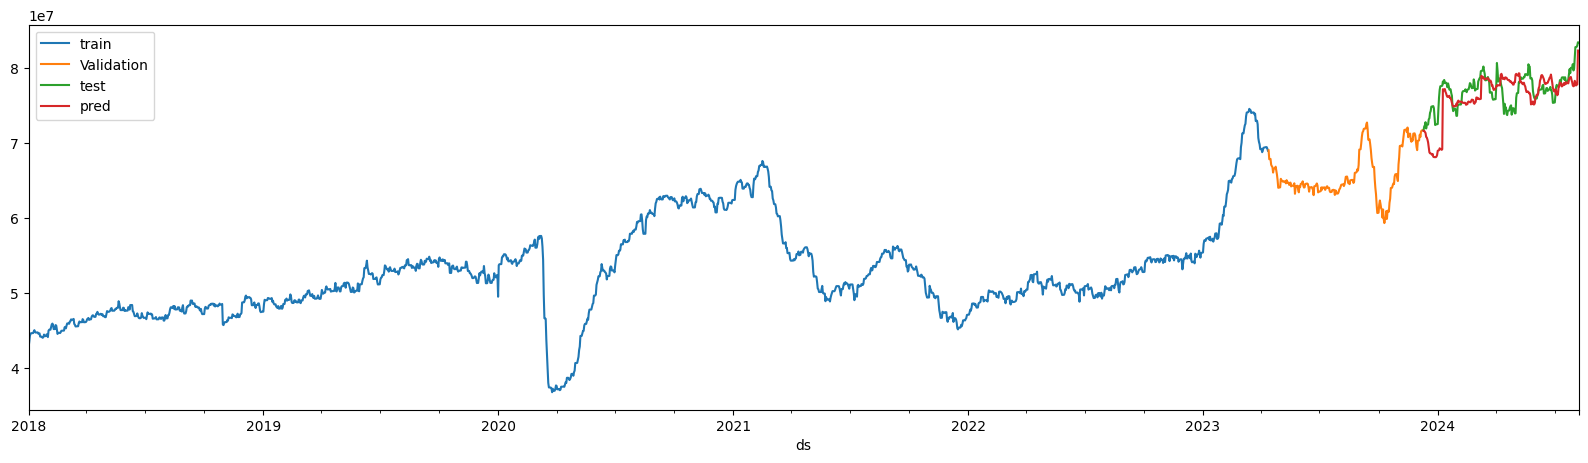

In [85]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(20, 5))
tr['y'].plot(ax=ax, label='train')
val['y'].plot(ax=ax, label='Validation')
ts['y'].plot(ax=ax, label='test')
predictions_4_backtesting.plot(ax=ax, label='predictions')
ax.legend();

In [104]:
metricas_lightbm_6= calculate_metrics(ts['y'],predictions_4_backtesting)

In [107]:
# Comparar resultados
resultados = pd.DataFrame({
    'Model': ['Lightbm solo variable objetivo','Lightbm solo variable objetivo Backtesting','Lightbm solo Variable Objetivos Mejores parámetros backtesting','Lightbm Variables Exógenas','Lightbm Variables Exógenas Backtesting','Lightbm Variables Exógenas Mejores parámetros Backtesting'],
    'MSE': [metricas_lightbm[0],metricas_lightbm_2[0],metricas_lightbm_3[0],metricas_lightbm_4[0],metricas_lightbm_5[0],metricas_lightbm_6[0]],
    'RMSE': [metricas_lightbm[1],metricas_lightbm_2[1],metricas_lightbm_3[1],metricas_lightbm_4[1],metricas_lightbm_5[1],metricas_lightbm_6[1]],
    'MAE': [metricas_lightbm[2],metricas_lightbm_2[2],metricas_lightbm_3[2],metricas_lightbm_4[2],metricas_lightbm_5[2],metricas_lightbm_6[2]],
    'MAPE': [metricas_lightbm[3],metricas_lightbm_2[3],metricas_lightbm_3[3],metricas_lightbm_4[3],metricas_lightbm_5[3],metricas_lightbm_6[3]]
})

resultados

,Model,MSE,RMSE,MAE,MAPE
0,Lightbm solo variable objetivo,4.189593e+13,6.472706e+06,6.091808e+06,7.840348
1,Lightbm solo variable objetivo Backtesting,5.430451e+12,2.330333e+06,1.817724e+06,NaN
2,Lightbm solo Variable Objetivos Mejores paráme...,5.492737e+12,2.343659e+06,1.856041e+06,NaN
3,Lightbm Variables Exógenas,4.316569e+13,6.570060e+06,6.220681e+06,8.015927
4,Lightbm Variables Exógenas Backtesting,5.492737e+12,2.343659e+06,1.856041e+06,NaN
5,Lightbm Variables Exógenas Mejores parámetros ...,7.130060e+12,2.670217e+06,2.001239e+06,NaN
